In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("car data.csv")

In [3]:
df.sample(5)

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
119,Royal Enfield Thunder 500,2013,1.05,1.90,5400,Petrol,Individual,Manual,0
25,swift,2011,3.00,4.99,20000,Petrol,Dealer,Manual,0
158,Honda Dream Yuga,2017,0.48,0.54,8600,Petrol,Individual,Manual,0
260,city,2016,9.15,13.60,29223,Petrol,Dealer,Manual,0


In [4]:
df.shape

(301, 9)

In [5]:
# let's first check na value

df.isna().values.any() # so there is no any value

False

In [6]:
print("Fuel Type: ", df.Fuel_Type.unique())
print("Seller Type: ", df.Seller_Type.unique())
print("Transmission: ", df.Transmission.unique())
print("Owner: ", df.Owner.unique())

Fuel Type:  ['Petrol' 'Diesel' 'CNG']
Seller Type:  ['Dealer' 'Individual']
Transmission:  ['Manual' 'Automatic']
Owner:  [0 1 3]


In [7]:
# year indicates a purchased year of car, it's basically use for calculating how many years old that car

# for that we need to subtract year from current year

from datetime import datetime

df["Current_year"] = datetime.now().year

# now let's subtract Year from Current Year
df["Year"] = df.Current_year - df.Year


In [8]:
# now let's drop current year we don't need it

df.drop(columns="Current_year", axis = 1, inplace = True)

In [9]:
# let's encode text or categorical data using one hot encoding
# let's create  dummy variables for Fuel_Type Seller_Type and Transmission

dummy = pd.get_dummies(df[["Fuel_Type", "Seller_Type", "Transmission"]], drop_first = True)
# drop first columns for preventing dummy variable trape
# for Fuel_Type CNG will be Removed, for Seller Type Dealer will be removed and fo Transmission Automatic remove
df = pd.concat( [df, dummy], axis = 1)
# now we don't need that original text data columns so let's drop it
df.drop(columns = ["Fuel_Type", "Seller_Type", "Transmission"], inplace = True)

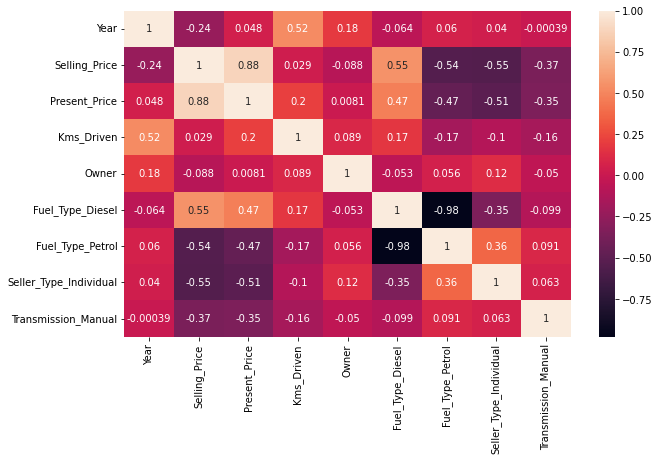

In [10]:
# let's get a corelation of our data

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize = (10, 6))
sns.heatmap(df.corr(), annot = True)
plt.show()

In [11]:
# let's encode Car_Name text data using one hot encoding

# for this let's convert first Car_Names data into lowercase

df.Car_Name = df.Car_Name.str.lower()

dummy = pd.get_dummies(df.Car_Name, drop_first = True)
# here we dropped first columns which is 800 for prevent dummy variable trap 

df = pd.concat([df, dummy], axis = 1)
# now we don't need Car_Name columns so let's drop it
df.drop("Car_Name", axis = 1, inplace = True)

In [12]:
# now let's create a feature matrix X and target vector y

X = df.drop(columns="Selling_Price")
y = df.Selling_Price

In [13]:
# let's find important feature using ExtraTreesRegressor model 

from sklearn.ensemble import ExtraTreesRegressor

etr = ExtraTreesRegressor()
etr.fit(X, y)
important_features = etr.feature_importances_

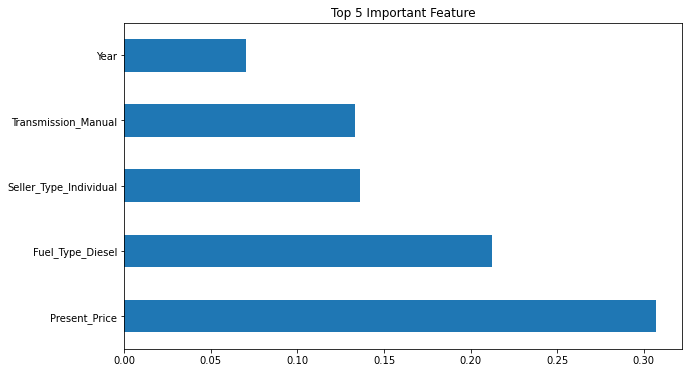

In [14]:
# let's get top important features

important_features = pd.Series(important_features, index = X.columns).sort_values(ascending = False)
# let's plot top 5 important feature

plt.figure(figsize = (10, 6))
important_features[:5].plot(kind = "barh")
plt.title("Top 5 Important Feature")

plt.show()

In [15]:
# let's divide our data into train and test part
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [16]:
# so let's hypertuning parameter and find best algorithm with it's best parameter

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [17]:
# let's create a dict for paramer


algos = {
    "Linear Regression": {
        "model": LinearRegression(),
        "param":{
            "normalize":[True, False]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(),
        "param": {
            "criterion": ["mse", "friedman_mse"],
            "splitter": ["best", "random"]
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(),
        "param": {
            "n_estimators": [int(x) for x in np.linspace(100, 1200, 12)],
            "max_features": ["auto", "sqrt"],
            "max_depth": [int(x) for x in np.linspace(5, 30, 6)],
            "min_samples_split": [2, 5, 10, 15, 100],
            "min_samples_leaf": [1, 2, 5, 10]
        }
    }
}

In [19]:
# let's find best algotithm with it's best parameter
# here we are going to use Randomize Search cv for hyperparamter tuninig

from sklearn.model_selection import RandomizedSearchCV

best_models = {}
scores = []
for model_name, values in algos.items():
    model_tunning = RandomizedSearchCV(values["model"], values["param"], n_iter=10, cv = 5, n_jobs = -1)
    model_tunning.fit(X_train, y_train)
    
    best_models[model_name] = model_tunning
    scores.append({
        "Model": model_name,
        "Best Parameters": model_tunning.best_params_,
        "Best Score": model_tunning.best_score_
    })
    
pd.DataFrame(scores)

OSError: [Errno 22] Invalid argument

In [ ]:
# In above we can see that Decision Tree is best algorithm with 92% accuracy
# but let's test all the algorithm on our test data set

for name, model in best_models.items():
    print(name, " : ", model.score(X_test, y_test))


##### so we can see above when we test those trained model using test data we get random forest is best algorithm with 96% accuracy 

In [ ]:
# let's take our final model
final_model = best_models["Random Forest"]

In [ ]:
# so here we take Random Forest model for our problem

def predict_price(year, present_price, kms, owner, diesel, petrol, individual, manual, vehicle):
    vehicle_index = np.where(X.columns == vehicle.lower())[0][0]
    X_pred = np.zeros_like(X.columns)
    
    feature_list = [year, present_price, kms, owner, diesel, petrol, individual, manual]
    count = 0
    for f in feature_list:
        X_pred[count] = f
        count += 1
    
    if vehicle_index > 0:
        X_pred[vehicle_index] = 1
    
    result = final_model.predict([X_pred])
    
    return result


In [ ]:
predict_price(7, 9.54, 43000, 0, 1, 0, 0, 1, "sx4")

In [ ]:
# our model is working perfectly fine with around 96% accuracy
# let's save our model as binary file

import pickle

with open("model.pkl", "wb") as f:
    pickle.dump(final_model, f)

In [ ]:
# let's save json file of our columns, it's use in frontend

import json

column_dict = {"data_columns": X.columns.to_list()}

with open("columns.json", "w") as f:
    json.dump(column_dict, f)